In [23]:
import torchvision
from torchvision import transforms #Torch is only used to load FashionMNIST data
import numpy as np

import autodiff as ad



# Examples

### Basic operations

In [24]:
v1 = ad.Variable(7, 'v1')
v2 = ad.Variable(8, 'v2')
c1 = ad.Constant(9, 'c1')

L = v1 + v2*v1 + c1 + 7

L.return_children()

{add10/['add9', 'c1'],
 add11/['add10', 'c7'],
 add9/['v1', 'mul3'],
 c1/9,
 c7/7,
 mul3/['v2', 'v1'],
 v1/7,
 v2/8}

### Topological sort

In [25]:
L.set_ordering()
L.ordering

[v1/7,
 v2/8,
 mul3/['v2', 'v1'],
 add9/['v1', 'mul3'],
 c1/9,
 add10/['add9', 'c1'],
 c7/7,
 add11/['add10', 'c7']]

### Backward pass

In [26]:
L.backward_pass()

{'v1': 9,
 'v2': 7,
 'mul3': 1,
 'add9': 1,
 'c1': 1,
 'add10': 1,
 'c7': 1,
 'add11': 1}

### Tensor contractions

In [27]:
A = ad.Variable(np.arange(60.).reshape(3,4,5), 'A')
B = ad.Variable(np.arange(120.).reshape(4,5,6), 'B')
C = ad.Variable(np.arange(18).reshape(3,6), 'C')

Q = ad.tensorcontract(A, B, axes=([1, 2], [0, 1]))

L = ad.tensorcontract(Q, C, axes=([0], [0]))

L.set_ordering()
L.backward_pass()

{'A': array([[[   55.,   145.,   235.,   325.,   415.],
         [  505.,   595.,   685.,   775.,   865.],
         [  955.,  1045.,  1135.,  1225.,  1315.],
         [ 1405.,  1495.,  1585.,  1675.,  1765.]],
 
        [[  145.,   451.,   757.,  1063.,  1369.],
         [ 1675.,  1981.,  2287.,  2593.,  2899.],
         [ 3205.,  3511.,  3817.,  4123.,  4429.],
         [ 4735.,  5041.,  5347.,  5653.,  5959.]],
 
        [[  235.,   757.,  1279.,  1801.,  2323.],
         [ 2845.,  3367.,  3889.,  4411.,  4933.],
         [ 5455.,  5977.,  6499.,  7021.,  7543.],
         [ 8065.,  8587.,  9109.,  9631., 10153.]]]),
 'B': array([[[ 600.,  660.,  720.,  780.,  840.,  900.],
         [ 618.,  681.,  744.,  807.,  870.,  933.],
         [ 636.,  702.,  768.,  834.,  900.,  966.],
         [ 654.,  723.,  792.,  861.,  930.,  999.],
         [ 672.,  744.,  816.,  888.,  960., 1032.]],
 
        [[ 690.,  765.,  840.,  915.,  990., 1065.],
         [ 708.,  786.,  864.,  942., 1020., 109

# Logistic regression model for FashionMNIST

### Data set

In [28]:
class FashionMNIST:
    
    def __init__(self, batch_size=32, resize=(28, 28)):
        self.root = '/Users/noahbittermann/PycharmProjects/d2l-implementations'
        self.batch_size = batch_size
        self.resize = resize
        trans = transforms.Compose([transforms.Resize(self.resize), transforms.ToTensor()])
        self.torch_train = torchvision.datasets.FashionMNIST(root=self.root, train=True, transform=trans, download=True)
        self.torch_val = torchvision.datasets.FashionMNIST(root=self.root, train=False, transform=trans, download=True)

    def text_labels(self, indices):
        """Return text labels."""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def torch_to_numpy(self):
        
        train_inputs = np.zeros((len(self.torch_train), self.resize[0], self.resize[1]))
        train_labels = np.zeros(len(self.torch_train), dtype=int)

        val_inputs = np.zeros((len(self.torch_val), self.resize[0], self.resize[1]))
        val_labels = np.zeros(len(self.torch_val), dtype=int)
        
        for index, observation in enumerate(self.torch_train):
            train_inputs[index] = observation[0]
            train_labels[index] = int(observation[1])

        for index, observation in enumerate(self.torch_val):
            val_inputs[index] = observation[0]
            val_labels[index] = int(observation[1])

        self.train_inputs = train_inputs
        self.train_labels = train_labels
        
        self.val_inputs = val_inputs
        self.val_labels = val_labels
   

### Model

In [29]:
class SoftmaxRegression:

    def __init__(self, batch_size, num_features, num_classes, lr, sigma=0.01):    

        self.batch_size = batch_size
        self.num_features = num_features
        self.num_classes = num_classes
        self.lr = lr

        self.params = {
            'W': ad.Variable(np.random.normal(loc=0, scale=sigma, size=(self.num_features, self.num_classes)), 'W'),
            'b': ad.Variable(np.zeros((1, num_classes)), 'b')
        }

        
    def forward(self, train_inputs):
        '''Takes in numpy array of inputs'''
        
        X = ad.Constant(train_inputs.reshape(-1, self.num_features), 'inputs')
        
        affine_trans = ad.tensorcontract(X, self.params['W'], axes=([1], [0])) + self.params['b']
        
        logprobs = ad.logsoft(affine_trans)
        
        return logprobs

    def loss(self, y, y_hat):
        return ad.cross_entropy(y, y_hat)*(1/len(y))
        

    def inference(self, inputs):

        Y_hat = self.forward(inputs).value

        predictions = Y_hat.argmax(axis=1)

        return predictions

    def accuracy(self, Y, inputs):

        predictions = self.inference(inputs)

        compare = predictions == Y

        return compare.mean()


### Optimizer

In [30]:
## Define the trainer

class SGD_optimizer:
    
    def step(self, model, L):
        L.set_ordering()
        L.backward_pass()
        for key in model.params:
            model.params[key].value -= model.lr * model.params[key].gradient
            

    def zero_grad(self, model):
        for key in model.params:
            if model.params[key].gradient is not None:
                model.params[key].gradient = None
        
    

### Trainer

In [32]:

class Trainer:
    
    def __init__(self, gradient_clip_val=0):
        
        self.gradient_clip_val = gradient_clip_val

    
    def fit(self, model, data, max_epochs):

        #format data
        data.torch_to_numpy()

        #load data
        num_batches = int(np.ceil(data.train_inputs.shape[0] / data.batch_size))
        
        self.train_input_loader = [data.train_inputs[i*data.batch_size: (i + 1)*data.batch_size] for i in range(num_batches)]
        self.train_label_loader = [data.train_labels[i*data.batch_size: (i + 1)*data.batch_size] for i in range(num_batches)]

        self.val_input_loader = [data.val_inputs[i*data.batch_size: (i + 1)*data.batch_size] for i in range(num_batches)]
        self.val_label_loader = [data.val_labels[i*data.batch_size: (i + 1)*data.batch_size] for i in range(num_batches)]

        #initialize the optimizer
        self.optimizer = SGD_optimizer()
        
        train_losses = []
        train_accuracies = []

        val_losses = []
        val_accuracies = []
        
        self.epoch = 0
        for epoch in range(max_epochs):

            running_loss = 0 
            running_accuracy = 0
            for i in range(num_batches):

                train_L = model.loss(self.train_label_loader[i], model.forward(self.train_input_loader[i]))
                
                self.optimizer.step(model, train_L)
                self.optimizer.zero_grad(model)

                running_loss += train_L.value / num_batches
                running_accuracy += model.accuracy(self.train_label_loader[i], self.train_input_loader[i]) / num_batches


            train_losses.append(running_loss)
            train_accuracies.append(running_accuracy)
            
            val_L = model.loss(data.val_labels, model.forward(data.val_inputs))
            val_losses.append(val_L.value)

            val_accuracy = model.accuracy(data.val_labels, data.val_inputs)
            val_accuracies.append(val_accuracy)

            
            print(f'epoch {epoch + 1}/{max_epochs}, train loss: {np.round(running_loss, 4)}, val loss: {np.round(val_L.value, 4)}, train accuracy:  {np.round(running_accuracy, 4)}, val accuracy: {np.round(val_accuracy, 4)}', end='\r')

            running_loss = 0
            running_accuracy = 0

        return train_losses, val_losses, train_accuracies, val_accuracies
                

### Initialize the data set, model, and trainer

In [33]:
img_size = (28,28)
batch_size = 32

FashionData = FashionMNIST(batch_size=batch_size, resize=img_size)

FashionModel = SoftmaxRegression(batch_size=batch_size, num_features=img_size[0]*img_size[1], num_classes=10, lr=0.01)

FashionTrainer = Trainer()

### Fit to the data

In [34]:
history = FashionTrainer.fit(FashionModel, FashionData, 100)

### Plot metrics

Text(0.5, 1.0, 'accuracy')

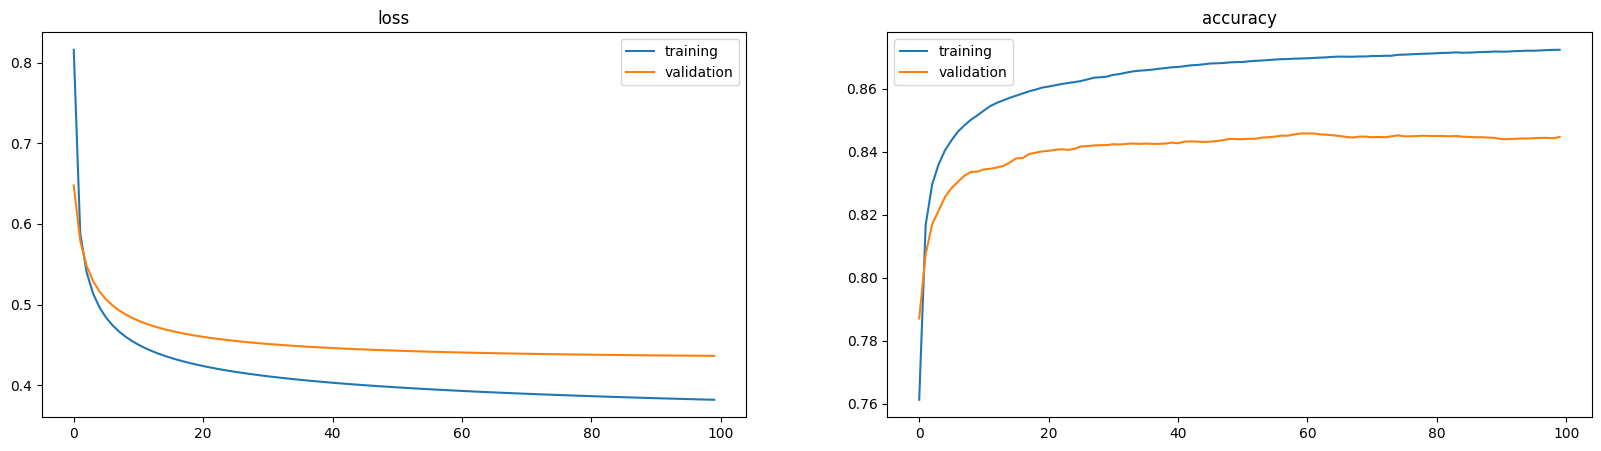

In [35]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))
ax1.plot(history[0], label = 'training')
ax1.plot(history[1], label = 'validation')
ax2.plot(history[2], label = 'training')
ax2.plot(history[3], label = 'validation')
ax1.legend()
ax2.legend()

ax1.set_title('loss')
ax2.set_title('accuracy')
